In [2]:
# 1. Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Di chuyển vào thư mục dự án
import os
# Sửa đường dẫn này đúng với nơi bạn lưu trên Drive
os.chdir('/content/drive/MyDrive/PBL4/MI-EEG-1D-CNN')

# 3. Cài đặt thư viện (Dựa trên file environment.yml trong folder docker/ hoặc docs/)
# Chúng ta cài thủ công các gói chính để nhanh gọn trên Colab
!pip install tensorflow==2.3
!pip install imbalanced-learn mne matplotlib scikit-learn
!pip install wget

ValueError: mount failed

In [ ]:
import sys
import os
sys.path.append(os.getcwd())
print("Đã thêm đường dẫn hiện tại vào hệ thống:", os.getcwd())

Đã thêm đường dẫn hiện tại vào hệ thống: /content/drive/MyDrive/PBL4/MI-EEG-1D-CNN


In [ ]:
# Cách 2: Dùng đường dẫn tuyệt đối (Chắc chắn nhất)
!PYTHONPATH=/content/drive/MyDrive/PBL4/MI-EEG-1D-CNN python dataset_generator/generator.py

Streaming output truncated to the last 5000 lines.
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from dataset/original/S058/S058R10.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from dataset/original/S058/S058R12.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from dataset/original/S058/S058R14.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('B'), np.str_('F'), np.str_('L'), np.str_('LR'), np.str_('R')]
Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18

In [ ]:
!PYTHONPATH=. python models/train_e.py

2026-01-07 05:09:51.690726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767762591.843627   13851 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767762591.890102   13851 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767762592.206419   13851 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767762592.206462   13851 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767762592.206467   13851 computation_placer.cc:177] computation placer alr

In [ ]:
!PYTHONPATH=. python models/hand_test/e_no_batch.py

2026-01-07 05:32:15.907412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767763935.941012   20041 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767763935.956205   20041 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767763935.979352   20041 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767763935.979394   20041 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767763935.979398   20041 computation_placer.cc:177] computation placer alr

In [ ]:
!pip install wget

In [ ]:
!pip install mne

In [ ]:
import os
import sys
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from google.colab import drive

# --- 1. KẾT NỐI GOOGLE DRIVE & CÀI ĐẶT ĐƯỜNG DẪN ---
# Mount Drive (Nếu chưa mount)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# ĐÂY LÀ ĐƯỜNG DẪN DỰA THEO ẢNH BẠN GỬI TRƯỚC ĐÓ
project_path = "/content/drive/MyDrive/PBL4/MI-EEG-1D-CNN"

# Kiểm tra xem đường dẫn có đúng không
if not os.path.exists(project_path):
    print(f"❌ LỖI: Không tìm thấy thư mục dự án tại: {project_path}")
    print("👉 Hãy kiểm tra lại xem folder 'PBL4' hoặc 'MI-EEG-1D-CNN' có bị đổi tên không.")
    # Dừng chương trình bằng cách raise lỗi (thay vì sys.exit để đỡ bị lỗi loằng ngoằng)
    raise RuntimeError("Sai đường dẫn thư mục project.")
else:
    print(f"✅ Đã tìm thấy dự án tại: {project_path}")

# Thêm vào sys.path để Python tìm được module
if project_path not in sys.path:
    sys.path.append(project_path)

# Chuyển thư mục làm việc về đó luôn để load dataset cho dễ
os.chdir(project_path)
print(f"📂 Thư mục làm việc hiện tại: {os.getcwd()}")

# --- 2. IMPORT MODULE (Giờ mới import được) ---
try:
    from model_set.models import HopefullNet
    from data_processing.general_processor import Utils
    print("✅ Import thành công model và utils.")
except ImportError as e:
    print("❌ Vẫn lỗi Import. Hãy chụp ảnh cấu trúc thư mục trong tab 'Files' bên trái gửi tôi.")
    raise e

# --- 3. CẤU HÌNH MODEL ---
save_path = "dataset/saved_models/roi_e"
# Tên file model - Bạn kiểm tra trong folder xem nó tên là bestModel.h5 hay final_model.keras
# Code train trước đó lưu là bestModel.h5
model_file = os.path.join(save_path, "bestModel.h5")

if not os.path.exists(model_file):
    print(f"❌ Lỗi: Không tìm thấy file model tại {model_file}")
    print("👉 Hãy kiểm tra trong Google Drive xem file model nằm ở đâu.")
    raise RuntimeError("Không tìm thấy file model.")

# --- 4. LOAD DỮ LIỆU (Chỉ lấy phần Test) ---
print("⏳ Đang load dữ liệu để test (Mất khoảng 1-2 phút)...")
source_path = "dataset/paper/"
channels = Utils.combinations["e"]
exclude = [38, 88, 89, 92, 100, 104]
subjects = [n for n in np.arange(1, 110) if n not in exclude]

# Load toàn bộ
x, y = Utils.load(channels, subjects, base_path=source_path)
y_one_hot = Utils.to_one_hot(y, by_sub=False)
reshaped_x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])

# Split Train/Test (Giống hệt lúc train)
print("✂️ Đang chia tập dữ liệu...")
_, x_valid_test_raw, _, y_valid_test_raw = train_test_split(
    reshaped_x, y_one_hot, stratify=y_one_hot, test_size=0.20, random_state=42
)

# Scale
x_test_valid_scaled_raw = minmax_scale(x_valid_test_raw, axis=1).astype(np.float32)

# Split Valid/Test
_, x_test_raw, _, y_test = train_test_split(
    x_test_valid_scaled_raw, y_valid_test_raw, stratify=y_valid_test_raw, test_size=0.50, random_state=42
)

# Reshape
n_channels = 2
x_test = x_test_raw.reshape(x_test_raw.shape[0], int(x_test_raw.shape[1]/n_channels), n_channels)

print(f"✅ Dữ liệu Test đã sẵn sàng: {x_test.shape}")

# --- 5. LOAD MODEL & PREDICT ---
# --- 5. LOAD MODEL & PREDICT (CÁCH FIX LỖI) ---
print("🤖 Đang khởi tạo model thủ công...")

try:
    # 1. Tự tạo model mới từ Code (Thay vì load từ file)
    model = HopefullNet()

    # 2. "Build" model bằng cách chạy thử một mẫu dữ liệu giả
    # Input shape là (Batch_size, Time_steps, Channels) -> (1, 640, 2)
    dummy_input = tf.zeros((1, 640, 2))
    _ = model(dummy_input)
    print("✅ Đã khởi tạo kiến trúc model thành công.")

    # 3. Chỉ load trọng số (Weights) từ file h5
    print(f"📥 Đang nạp trọng số từ: {model_file}")
    model.load_weights(model_file)
    print("✅ Nạp trọng số thành công!")

except Exception as e:
    print(f"❌ Vẫn lỗi: {e}")
    # Nếu lỗi, in gợi ý sửa file gốc
    print("\n⚠️ GỢI Ý SỬA GỐC: Bạn cần mở file 'model_set/models.py', tìm hàm __init__ của HopefullNet")
    print("Sửa: def __init__(self):")
    print("Thành: def __init__(self, **kwargs):")
    print("           super().__init__(**kwargs)")
    raise e

# --- 6. CHẤM ĐIỂM ---
print("📊 Đang chấm điểm (Predict)...")
# Compile lại model trước khi evaluate (cần thiết sau khi load weights thủ công)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

loss, acc = model.evaluate(x_test, y_test, verbose=1)
print(f"\n🏆 ĐỘ CHÍNH XÁC TRÊN TẬP TEST: {acc*100:.2f}%")

# --- 7. BÁO CÁO CHI TIẾT ---
y_pred = model.predict(x_test)
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)
target_names = ["B (Baseline)", "R (Right)", "RL (Right-Left)", "L (Left)", "F (Feet)"]

print("\n--- CONFUSION MATRIX ---")
print(confusion_matrix(y_test_class, y_pred_class))

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test_class, y_pred_class, target_names=target_names))

# --- 6. BÁO CÁO CHI TIẾT ---
y_pred = model.predict(x_test)
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)
target_names = ["B (Baseline)", "R (Right)", "RL (Right-Left)", "L (Left)", "F (Feet)"]

print("\n--- CONFUSION MATRIX ---")
print(confusion_matrix(y_test_class, y_pred_class))

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test_class, y_pred_class, target_names=target_names))

✅ Đã tìm thấy dự án tại: /content/drive/MyDrive/PBL4/MI-EEG-1D-CNN
📂 Thư mục làm việc hiện tại: /content/drive/MyDrive/PBL4/MI-EEG-1D-CNN
✅ Import thành công model và utils.
⏳ Đang load dữ liệu để test (Mất khoảng 1-2 phút)...
✂️ Đang chia tập dữ liệu...
✅ Dữ liệu Test đã sẵn sàng: (11107, 640, 2)
🤖 Đang khởi tạo model thủ công...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'hopefull_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


✅ Đã khởi tạo kiến trúc model thành công.
📥 Đang nạp trọng số từ: dataset/saved_models/roi_e/bestModel.h5
✅ Nạp trọng số thành công!
📊 Đang chấm điểm (Predict)...
348/348 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9421 - loss: 0.2841

🏆 ĐỘ CHÍNH XÁC TRÊN TẬP TEST: 94.30%
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

--- CONFUSION MATRIX ---
[[5309   68   78   34   73]
 [  24 1333    9    1   12]
 [  34   12 1319   10   28]
 [  71   17   34 1236   26]
 [  50   22   18   12 1277]]

--- CLASSIFICATION REPORT ---
                 precision    recall  f1-score   support

   B (Baseline)       0.97      0.95      0.96      5562
      R (Right)       0.92      0.97      0.94      1379
RL (Right-Left)       0.90      0.94      0.92      1403
       L (Left)       0.96      0.89      0.92      1384
       F (Feet)       0.90      0.93      0.91      1379

       accuracy                           0.94     11107
      macro avg       0.93      0.94      0.93     11107
   weighted avg       0.94 

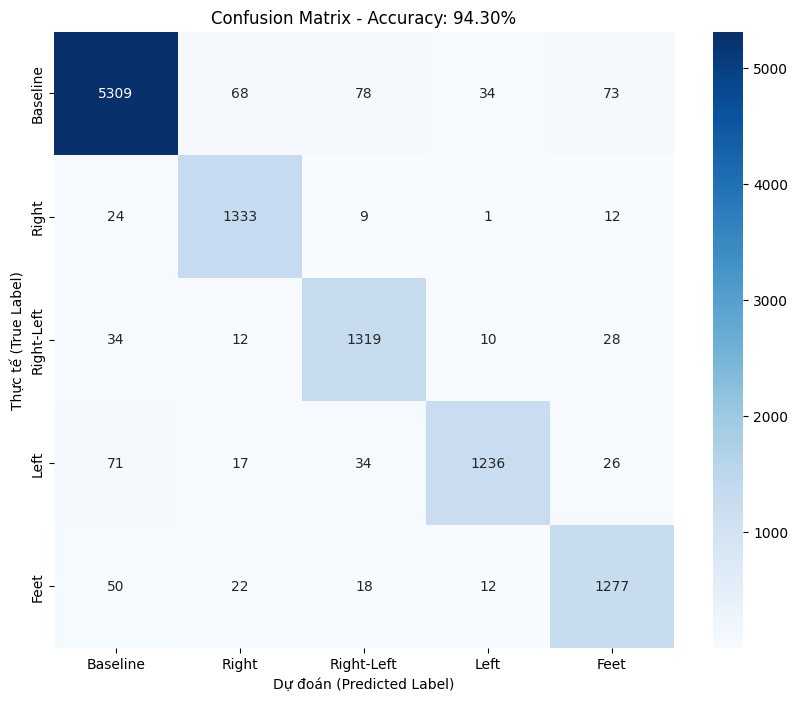

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Số liệu từ kết quả của bạn (Copy vào đây để vẽ)
cm = np.array([
    [5309, 68, 78, 34, 73],
    [24, 1333, 9, 1, 12],
    [34, 12, 1319, 10, 28],
    [71, 17, 34, 1236, 26],
    [50, 22, 18, 12, 1277]
])

target_names = ["Baseline", "Right", "Right-Left", "Left", "Feet"]

# Vẽ biểu đồ
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)

plt.title('Confusion Matrix - Accuracy: 94.30%')
plt.ylabel('Thực tế (True Label)')
plt.xlabel('Dự đoán (Predicted Label)')
plt.show()